In [17]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from matplotlib import pyplot as plt

import util
reload(util);

import luna_preprocess
reload(luna_preprocess);

In [ ]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

In [ ]:
f = '../LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd'

In [ ]:
annt_df[annt_df.file==f]

In [ ]:
itk = sitk.ReadImage(f)

In [ ]:
origin = np.asarray(itk.GetOrigin(), dtype=np.float)
spacing = np.asarray(itk.GetSpacing(), dtype=np.float) 
image = sitk.GetArrayFromImage(itk)

In [ ]:
new_spacing = np.asarray([1] * 3, dtype=np.float)

In [ ]:
resampled_image = util.resample(image, spacing, new_spacing)

In [ ]:
lung_mask = util.segment_lung_mask_v2(resampled_image, 1)

In [ ]:
hero = lung_mask.astype(np.uint8)
bg = hero[0, 0, 0]
        # x, y, z                                                                                  
v_margin = np.round(2.0 / new_spacing).astype(np.int)
slices = util.find_bbox(hero, v_margin[::-1], bg)
offsets = [s.start for s in slices]
origin = origin + new_spacing * offsets[::-1]
shrink_image = resampled_image[slices]
lung_mask = lung_mask[slices]

In [ ]:
spacing = new_spacing

In [ ]:
nodules = []
df = annt_df[annt_df.file==f]
for _, cur_row in df.iterrows():
    nod_x = cur_row["coordX"]
    nod_y = cur_row["coordY"]
    nod_z = cur_row["coordZ"]
    diam = cur_row["diameter_mm"]
    nodules.append((nod_x, nod_y, nod_z, diam))

In [ ]:
nodules

In [ ]:
spacing

In [ ]:
nodule = nodules[1]

In [ ]:
nodule

In [ ]:
from skimage import morphology
nod_x, nod_y, nod_z, diam = nodule
center = np.asarray([nod_x, nod_y, nod_z], dtype=np.float)
radius = diam / 2.0
v_center = np.round((center - origin) / 1).astype(np.int)
v_radius = int(round(radius / 1))
ball = morphology.ball(v_radius)
ans = np.zeros(resampled_image.shape)
v_o = np.maximum(0, v_center - v_radius)  # x, y, z  

In [ ]:
[
    (v_o[2], v_o[2]+ball.shape[0]),
    (v_o[1], v_o[1]+ball.shape[1]),
    (v_o[0], v_o[0]+ball.shape[2])
]

In [ ]:
v_center

In [ ]:
hero = resampled_image[132]

In [ ]:
lm = util.segment_lung_mask_v1(resampled_image, 1)

In [ ]:
binary = np.stack([
        util._segment_lung_mask_v2_impl(im, 1)
        for im in resampled_image
    ])

In [ ]:
labels = measure.label(binary)
vals, counts = np.unique(labels, return_counts=True)
counts = counts[vals != 0]
vals = vals[vals != 0]
counts_and_vals = sorted(zip(counts, vals), key=lambda x: -x[0])


In [ ]:
max_label_counts, max_label = counts_and_vals[0]
max_label_counts, max_label

In [ ]:
max2_label_counts, max2_label = counts_and_vals[1]
max2_label_counts, max2_label

In [ ]:
436648 / 1933217.0

In [ ]:
binary[(labels!=max_label)&(labels!=max2_label)] = 0

In [ ]:
lmm = util._dilate_mask(binary, 1)

In [ ]:
plt.imshow(lmm[132])

In [ ]:
plt.imshow(image[132], cmap='gray')

In [ ]:
ans.shape

In [ ]:
ans[v_o[2]:v_o[2]+ball.shape[0],
    v_o[1]:v_o[1]+ball.shape[1],
    v_o[0]:v_o[0]+ball.shape[2]] = ball

In [ ]:
v_o

In [ ]:
plt.hist(annt_df['diameter_mm'], bins=100);
np.percentile(annt_df['diameter_mm'], [0, 50, 100])

In [ ]:
def sample_file_ids(min_num_nodules=1):
    t = annt_df.groupby('file').count()
    t = set([luna_preprocess.get_file_id(x)
             for x in list(t[t.seriesuid>min_num_nodules].index)])
    t1 = [x[0:-11] for x in os.listdir('../LUNA16/output')]
    return list(set(t1).intersection(t))

In [ ]:
file_ids = sample_file_ids(1)

In [ ]:
file_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764'

In [ ]:
#image = luna_preprocess.Image()
#image.init(file_dict[file_id], annt_df,
#           iso_spacing=1.0, shrink_margin=2.0)

In [ ]:
image = luna_preprocess.Image()
image.load(file_id)

In [ ]:
nodules = image.get_v_nodules()
print '# of nodules = %d'%len(nodules)

In [ ]:
nodule_idx = 2
nodule = nodules[nodule_idx]

In [ ]:
x, y, z, d = nodule
plt.figure()
plt.imshow(image.masked_lung[z], cmap='gray')
circle = plt.Circle((x, y), d/2, color='r', fill=False)
plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image.masked_nodule(nodule_idx)[z], cmap='gray')

In [ ]:
sigmas = util.get_dot_enhance_filter_sigmas(d0=3, d1=33, N=5)

In [ ]:
enhance_2d = util.enhance_filter_2d(image.masked_lung[z], sigmas, 'dot')

In [ ]:
plt.imshow(enhance_2d>20, cmap='gray')
circle = plt.Circle((x, y), d, color='r', fill=False)
plt.gca().add_artist(circle)

In [ ]:
enhance_3d = util.enhance_filter_3d(image.masked_lung, sigmas, 'dot')

In [ ]:
plt.imshow(enhance_3d[z]>20, cmap='gray')
circle = plt.Circle((x, y), d/2, color='r', fill=False)
plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image._nodule_masks[nodule_idx][z], cmap='gray')

In [ ]:
labels = measure.label(enhance_3d>20)

In [ ]:
vals, counts = np.unique(labels, return_counts=True)

In [ ]:
vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1

In [ ]:
idx = ((counts>=vol_min)&(counts<=vol_max))
vals = vals[idx]
counts = counts[idx]

In [ ]:
print '# of clusters = %d'%len(vals)

In [ ]:
label = vals[0]
slices = util.find_bbox((labels==label), margin=[0,0,0], bg=0)
slices

In [ ]:
ref_mask = image._nodule_masks[nodule_idx]

cand_labels = vals
overlaps = []
for cand_label in cand_labels:
    mask = (labels==cand_label)
    i = np.sum(np.logical_and(mask, ref_mask))
    u = np.sum(mask) + np.sum(ref_mask) - i
    overlaps.append(i / float(np.sum(mask)))

In [ ]:
np.argmax(overlaps), max(overlaps)

In [ ]:
mask = (labels==cand_labels[np.argmax(overlaps)])
[
    np.sum(np.logical_and(mask, ref_mask)),
    np.sum(mask),
    np.sum(ref_mask)
]

In [ ]:
mask = (labels==cand_labels[np.argmax(overlaps)])

In [ ]:
plt.imshow(image.masked_lung[z], cmap='gray')
plt.figure()
plt.imshow(mask[z], cmap='gray')

In [ ]:
root_dir = '../LUNA16/output_enhance'
enhance_3d_file_list = [
    os.path.join(root_dir, f)
    for f in os.listdir(root_dir)
]

In [ ]:
def eval_enhance_3d_quality(enhance_3d_file, d0, d1, th):
    image = luna_preprocess.Image()
    image.load(luna_preprocess.get_file_id(enhance_3d_file))
    enhance_3d = np.load(enhance_3d_file).items()[0][1]
    
    sigmas = util.get_dot_enhance_filter_sigmas(d0=d0, d1=d1, N=5)
    vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
    vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1
    
    labels = measure.label(enhance_3d>th)
    vals, counts = np.unique(labels, return_counts=True)
    cand_labels = vals[((counts>=vol_min)&(counts<=vol_max))]
    
    nodules = image.get_v_nodules()
    num_nodules = len(nodules)
    
    def eval_nodule(nod_idx):
        nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodules[nod_idx]
        ref_mask = image._nodule_masks[nod_idx]
        overlaps = []
        for cand_label in cand_labels:
            mask = (labels==cand_label)
            i = np.sum(np.logical_and(mask, ref_mask))
            u = np.sum(mask) + np.sum(ref_mask) - i
            overlaps.append(i / float(np.sum(mask)))
        return max(overlaps)
    
    return ([
        eval_nodule(nod_idx)
        for nod_idx in range(num_nodules)
    ], len(cand_labels))

In [ ]:
ans = []
for enhance_3d_file in enhance_3d_file_list:
    ans.append(eval_enhance_3d_quality(enhance_3d_file, d0=3, d1=33, th=3))

In [ ]:
import pickle
with open('ans.dat', 'w') as f:
    pickle.dump(ans, f)

In [ ]:
x = [b for a, c in ans for b in a]

In [ ]:
len(x) * 1.0 /sum([c for a, c in ans])

In [ ]:
sum(np.array(x)>0.2) / float(len(x))

In [ ]:
ans

In [ ]:
plt.hist(x, bins=80);

In [ ]:
d0=3
d1=33
th=20
enhance_3d_file = '../LUNA16/output_enhance/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949_dot.npz'
image = luna_preprocess.Image()
image.load(luna_preprocess.get_file_id(enhance_3d_file))
enhance_3d = np.load(enhance_3d_file).items()[0][1]
labels = measure.label(enhance_3d>th)

In [ ]:
sigmas = util.get_dot_enhance_filter_sigmas(d0=d0, d1=d1, N=5)
vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1
    
nod_idx = 0
nod_v_x, nod_v_y, nod_v_z, nod_v_d = image.get_v_nodules()[nod_idx]

In [ ]:
slice_z = nod_v_z
plt.figure()
plt.imshow(image._image[slice_z], cmap='gray')
plt.figure()
plt.imshow(image.masked_lung[slice_z], cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
#plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image.masked_nodule(nod_idx)[slice_z], cmap='gray')

In [ ]:
enhance_2d = util.enhance_filter_2d(image.masked_lung[nod_v_z], sigmas, 'dot')

In [ ]:
plt.imshow(enhance_2d>20, cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
plt.gca().add_artist(circle)

In [ ]:
plt.imshow(enhance_3d[nod_v_z]>3, cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
plt.gca().add_artist(circle)

In [ ]:
from scipy.ndimage.filters import gaussian_filter

In [ ]:
def _enhance_filter_3d_impl(image, sigma, kind):
    bg = image[0, 0, 0]
    fxx = gaussian_filter(image, sigma, order=(0, 0, 2) , mode='constant', cval=bg)
    fyy = gaussian_filter(image, sigma, order=(0, 2, 0) , mode='constant', cval=bg)
    fzz = gaussian_filter(image, sigma, order=(2, 0, 0) , mode='constant', cval=bg)
    fxy = gaussian_filter(image, sigma, order=(0, 1, 1) , mode='constant', cval=bg)
    fyz = gaussian_filter(image, sigma, order=(1, 1, 0) , mode='constant', cval=bg)
    fzx = gaussian_filter(image, sigma, order=(1, 0, 1) , mode='constant', cval=bg)
    a = np.zeros(list(image.shape) + [3, 3])
    a[:,:,:,0,0] = fxx
    a[:,:,:,1,1] = fyy
    a[:,:,:,2,2] = fzz
    a[:,:,:,0,1] = a[:,:,:,1,0] = fxy
    a[:,:,:,1,2] = a[:,:,:,2,1] = fyz
    a[:,:,:,0,2] = a[:,:,:,2,0] = fzx
    w, _ = np.linalg.eig(a)
    w = util.apply_argsort(w, np.argsort(np.abs(w)))
    lambda1 = w[:,:,:,2]
    lambda2 = w[:,:,:,1]
    lambda3 = w[:,:,:,0]
    return lambda1, lambda2, lambda3

In [ ]:
sigmas

In [ ]:
image._nodules[nod_idx][3]/4.0

In [ ]:
ans = _enhance_filter_3d_impl(image.masked_lung, 1.8571076617500002, 'dot')

In [ ]:
x = [
    ans[0][nod_v_z, nod_v_y, nod_v_x],
    ans[1][nod_v_z, nod_v_y, nod_v_x],
    ans[2][nod_v_z, nod_v_y, nod_v_x]
]
x

In [ ]:
np.abs(x[2])**2/np.abs(x[0]) * 1.36587022**2

In [ ]:
np.abs(x[2])**2/np.abs(x[0]) * 1.8571076617500002**2

In [ ]:
enhance_3d[nod_v_z, nod_v_y, nod_v_x]

In [ ]:
image._image.shape

In [ ]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

In [ ]:
f = file_list[0]

In [ ]:
image = luna_preprocess.Image()
image.load(luna_preprocess.get_file_id(f))

In [ ]:
nodules = image.get_v_nodules()
nod_idx = 1
nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodules[nod_idx]

In [ ]:
image.masked_lung[nod_v_z].shape

In [ ]:
def pad_to_square(image):
    h, w = image.shape
    pad = abs(w - h) // 2
    if h < w:
        return np.pad(image, ((pad, w - h - pad), (0, 0)), 'edge')
    return np.pad(image, ((0, 0), (pad, h - w - pad)), 'edge')

In [ ]:
slice_z = np.clip(nod_v_z + 1, 0, image._image.shape[0] - 1)

final_image = image.masked_lung[slice_z]
final_image = transform.resize(util.normalize(pad_to_square(final_image), 0.0), [512, 512])
plt.figure()
plt.imshow(final_image, cmap='gray')

final_mask = image._nodule_masks[nod_idx][slice_z]
final_mask = transform.resize(pad_to_square(final_mask), [512, 512])
plt.figure()
plt.imshow(final_mask, cmap='gray')

plt.figure()
x = final_image.copy()
x[final_mask==0] = 0
plt.imshow(x, cmap='gray')

In [ ]:
x = np.load('../LUNA16/output_unet_data/subset0.npz')
images, nodule_masks = x['images'], x['nodule_masks']

In [ ]:
plt.figure()
plt.imshow(images[3][0], cmap='gray')
plt.figure()
plt.imshow(nodule_masks[3][0], cmap='gray')

In [ ]:
x = np.load('../LUNA16/output_unet_data/subset0.npz')

In [ ]:
images, nodule_masks = x['images'], x['nodule_masks']


In [ ]:
plt.figure()
plt.imshow(images[100][0], cmap='gray')
plt.figure()
plt.imshow(nodule_masks[100][0], cmap='gray')

In [2]:
from keras import backend as K
import tensorflow as tf
import luna_train_unet

Using TensorFlow backend.


In [3]:
K.set_image_dim_ordering('th')

In [4]:
K.image_dim_ordering()

'th'

In [5]:
with tf.device('/cpu:0'):
    model = luna_train_unet.get_unet()
    model.load_weights('./unet.hdf5')

In [6]:
imgs_train, imgs_mask_train = luna_train_unet.load_data(['subset0'])
mean = np.mean(imgs_train)  # mean for data centering                                       
std = np.std(imgs_train)  # std for data normalization   

In [7]:
data = np.load('../LUNA16/output_unet_data/subset6.npz')
images, nodule_masks = data['images'], data['nodule_masks']
images = (images - mean) / std
#images = np.load('../LUNA16/tutorial/testImages.npy')
#nodule_masks = np.load('../LUNA16/tutorial/testMasks.npy')

In [8]:
images.shape, nodule_masks.shape

((387, 1, 512, 512), (387, 1, 512, 512))

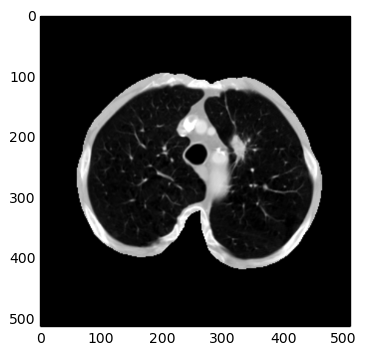

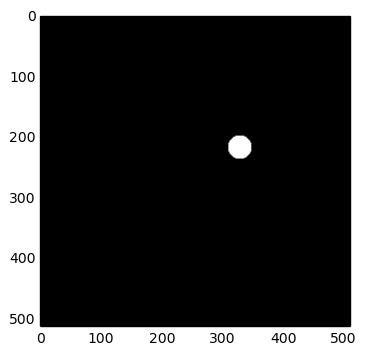

In [9]:
sample_idx = 11
plt.figure()
plt.imshow(images[sample_idx][0], cmap='gray')
plt.figure()
plt.imshow(nodule_masks[sample_idx][0], cmap='gray')

In [10]:
with tf.device('/cpu:0'):
    p = model.predict(images[sample_idx:sample_idx+1], verbose=True)

1/1 [==============================] - 3s


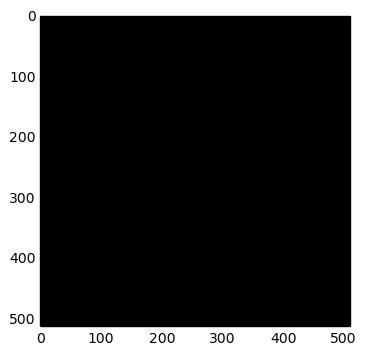

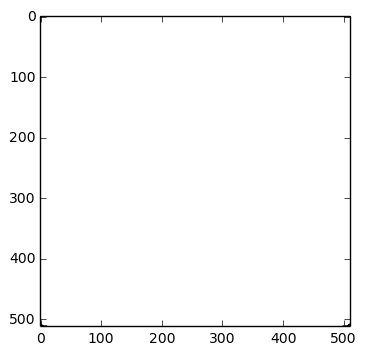

In [16]:
plt.figure()
plt.imshow(p[0][0]>np.mean(p[0][0]), cmap='gray')
plt.figure()
x = images[sample_idx][0].copy()
x[~(p[0][0]>0)] = 0
plt.imshow(x, cmap='gray')

In [135]:
np.mean(p)

1.5099937e-09